### Import section

In [1]:
from mongoengine import connect, disconnect
from settings import DevelopmentConfig, TestingConfig
from tests.factories.marketplace import UserFactory, ServiceFactory
import random


from recommender.engine.pre_agent.datasets import *
from recommender.engine.pre_agent.preprocessing import *
from recommender.engine.pre_agent.models import *

from recommender.models import User, Service, PytorchDataset

import time
from tqdm.auto import tqdm, trange

import torch
from torch.utils.data import random_split, DataLoader
from torch.optim import SGD
from torch.nn import BCELoss


from recommender.engine.pre_agent.training import *

from matplotlib import pyplot as plt

from tests.factories.populate_database import populate_users_and_services

### connect to database

##### testing database

In [2]:
disconnect()
connect(host=TestingConfig.MONGODB_HOST)

mongomock.MongoClient('localhost', 27017)

In [3]:
# Populate database with artificial data

COMMON_SERVICES_NUMBER = 10
NO_ONE_SERVICES_NUMBER = int(COMMON_SERVICES_NUMBER/10)
USERS_NUMBER = 10
K_COMMON_SERVICES_MIN = 3
K_COMMON_SERVICES_MAX = 7

populate_users_and_services(
    common_services_number=COMMON_SERVICES_NUMBER,
    no_one_services_number=NO_ONE_SERVICES_NUMBER,
    users_number=USERS_NUMBER,
    k_common_services_min=K_COMMON_SERVICES_MIN,
    k_common_services_max=K_COMMON_SERVICES_MAX
)

No one services creating...:   0%|          | 0/1 [00:00<?, ?it/s]

Common services creating...:   0%|          | 0/10 [00:00<?, ?it/s]

Users creating...:   0%|          | 0/10 [00:00<?, ?it/s]

##### development database

If you want to use development databse make sure that there is at least one user with at least on category/scientific_domain and least one accessed_service

In [4]:
# disconnect()
# connect(host=DevelopmentConfig.MONGODB_HOST)

### Precalculate tensors

In [5]:
precalc_users_and_service_tensors()

Calculating users dataframes...:   0%|          | 0/10 [00:00<?, ?it/s]

Saving users tensors...:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating services dataframes...:   0%|          | 0/11 [00:00<?, ?it/s]

Saving services tensors...:   0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
create_datasets()

Generating dataset...:   0%|          | 0/10 [00:00<?, ?it/s]

Spliting into Train/Valid/Test datasets...
finished!
Train/Valid/Test datasets saving...
finished!


(<torch.utils.data.dataset.Subset at 0x7f5f789e6b90>,
 <torch.utils.data.dataset.Subset at 0x7f5f7879f390>)

### Training

In [ ]:
# Get datasets and dataloaders
train_ds = load_last_dataset(TRAIN_DS_NAME)
valid_ds = load_last_dataset(VALID_DS_NAME)
test_ds = load_last_dataset(TEST_DS_NAME)

BATCH_SIZE = 32

train_ds_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_ds_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)
test_ds_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# Model
USER_FEATURES_DIM = train_ds[0][USERS].shape[0]
SERVICE_FEATURES_DIM = train_ds[0][SERVICES].shape[0]
USER_EMBEDDING_DIM = 32
SERVICE_EMBEDDING_DIM = 64

neural_cf_model = NeuralColaborativeFilteringModel(
    user_features_dim=USER_FEATURES_DIM,
    user_embedding_dim=USER_EMBEDDING_DIM,
    service_features_dim=SERVICE_FEATURES_DIM,
    service_embedding_dim=SERVICE_EMBEDDING_DIM,
)

loss_function = BCELoss()

LR = 0.01
optimizer = SGD(neural_cf_model.parameters(), lr=LR)

EPOCHS = 2000

losses, accuracies, val_losses, val_accuracies = train(
    model=neural_cf_model,
    epochs=EPOCHS,
    train_ds_dl=train_ds_dl,
    valid_ds_dl=valid_ds_dl,
    loss_function=loss_function,
    accuracy_function=accuracy_function,
    optimizer=optimizer
)

### Visualize loss

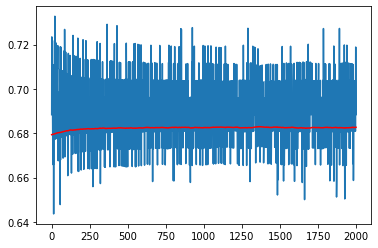

In [8]:
plt.plot([float(loss) for loss in losses])
plt.plot([float(loss) for loss in val_losses], color="red")
plt.show()

### Visualize accuracy

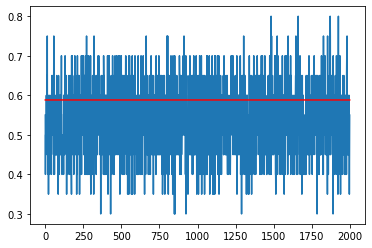

In [9]:
plt.plot([float(acc) for acc in accuracies])
plt.plot([float(acc) for acc in val_accuracies], color="red")
plt.show()

### Model Evaluation

In [10]:
loss, acc = evaluate(neural_cf_model, test_ds_dl, loss_function, accuracy_function)
print(f"Testing loss: {loss}, testing accuracy: {acc}")

Testing loss: 0.6959970593452454, testing accuracy: 0.5


### Model saving

Transformers are save automatically after creation and fitting inside raw_dataset_to_tensors function so only model should be saved manually.

In [11]:
save_module(neural_cf_model, name=NEURAL_CF)

### Inferention

Model loading:

In [12]:
neural_cf_model = load_last_module(NEURAL_CF)

Inferention data preparing

In [13]:
user = User.objects[0]
services = list(Service.objects)
service = services[0]

In [14]:
%%time
users_tensor, services_tensor = user_and_service_to_tensors(user, service)

CPU times: user 553 µs, sys: 0 ns, total: 553 µs
Wall time: 544 µs


In [15]:
%%time
prediction = neural_cf_model(users_tensor, services_tensor).item()

CPU times: user 808 µs, sys: 0 ns, total: 808 µs
Wall time: 592 µs


In [16]:
print(f"Inferenced probability: {prediction}")

Inferenced probability: 0.5373178720474243


In [17]:
%%time
users_tensor, services_tensor = user_and_services_to_tensors(user, services)

CPU times: user 4.06 ms, sys: 0 ns, total: 4.06 ms
Wall time: 3.75 ms


In [18]:
%time
predictions = neural_cf_model(users_tensor, services_tensor)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [19]:
print(f"Inferenced probabilities: {predictions}")

Inferenced probabilities: tensor([[0.5373],
        [0.5372],
        [0.5375],
        [0.5373],
        [0.5372],
        [0.5373],
        [0.5372],
        [0.5369],
        [0.5372],
        [0.5374],
        [0.5373]], grad_fn=<SigmoidBackward>)
